# Amaon Sentiment Analysis

# Imports

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

np.random.seed(1)

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter

import torch

### Dataset Location: https://www.kaggle.com/datasets/miriamodeyianypeter/sentiment-analysis-amazon-product-reviews/data

# Functions

In [100]:
def check_class_imbalance(df):
  y = df.values[:,-1]
  counter = Counter(y)
  for k,v in counter.items():
    per = v/len(y) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))

def sentiment_score(review, tokenizer, model):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits)) +1

def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(accuracy_score)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores
def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)

def svm_tune_grid_search(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    model = SVC()
    
    param_grid = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    
    return grid_search
def logistic_regression_tune_cv(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    param_grid = {
        'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
        'C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20, 50, 100, 400]
    }
    model = LogisticRegression(class_weight='balanced', penalty='l2', max_iter=2000)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
def grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
            
        grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
            
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Test accuracy for {name}: {accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Test Accuracy": accuracy,
                "Best Parameters": grid_search.best_params_
        })


    model_performance_df = pd.DataFrame(model_performance)
    print(model_performance_df)

In [101]:
PATH = "/Users/maukanmir/Downloads/amazon.csv"

In [102]:
eda_df = pd.read_csv(PATH, nrows=5000)
eda_df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,US,20876568,R3FWCZIGA1DKMF,B00LCHS1FG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,1,1,N,Y,great,Enjoy it and I don't know what I did with out it!,2015-06-14,1
4996,US,16202007,RAFVJ1UZRGT0B,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,1,1,N,Y,love it!,It was a father's day gift from my wife and da...,2015-06-14,1
4997,US,28118871,R2WAPN2YT8QNHV,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,1,1,N,Y,Five Stars,Fire tablets just keep getting better at a dec...,2015-06-14,1
4998,US,48285453,RPDTQ3CAMBPEG,B00LCHS1FG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,Y,70% satisfied,I have had this fire about a week now. I'm pre...,2015-06-14,0


# Check for Nulls and Dupes

In [103]:
print(f"Number of Null values: {eda_df.isna().sum()}")
print(f"Number of Dupe values: {eda_df.duplicated().sum()}")

Number of Null values: marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
sentiment            0
dtype: int64
Number of Dupe values: 0


In [104]:
eda_df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,US,20876568,R3FWCZIGA1DKMF,B00LCHS1FG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,1,1,N,Y,great,Enjoy it and I don't know what I did with out it!,2015-06-14,1
4996,US,16202007,RAFVJ1UZRGT0B,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,1,1,N,Y,love it!,It was a father's day gift from my wife and da...,2015-06-14,1
4997,US,28118871,R2WAPN2YT8QNHV,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,1,1,N,Y,Five Stars,Fire tablets just keep getting better at a dec...,2015-06-14,1
4998,US,48285453,RPDTQ3CAMBPEG,B00LCHS1FG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,Y,70% satisfied,I have had this fire about a week now. I'm pre...,2015-06-14,0


In [105]:
columns_of_interest = ["marketplace", "product_title", "product_category", "vine", "verified_purchase", "review_date"]

for col in columns_of_interest:
  unique_values = eda_df[col].unique()
  print(unique_values)
  print(len(unique_values))

['US']
1
['Fire HD 7, 7" HD Display, Wi-Fi, 8 GB']
1
['PC']
1
['N']
1
['Y' 'N']
2
['2015-08-31' '2015-08-30' '2015-08-29' '2015-08-28' '2015-08-27'
 '2015-08-26' '2015-08-25' '2015-08-24' '2015-08-23' '2015-08-22'
 '2015-08-21' '2015-08-20' '2015-08-19' '2015-08-18' '2015-08-17'
 '2015-08-16' '2015-08-15' '2015-08-14' '2015-08-13' '2015-08-12'
 '2015-08-11' '2015-08-10' '2015-08-09' '2015-08-08' '2015-08-07'
 '2015-08-06' '2015-08-05' '2015-08-04' '2015-08-03' '2015-08-02'
 '2015-08-01' '2015-07-31' '2015-07-30' '2015-07-29' '2015-07-28'
 '2015-07-27' '2015-07-26' '2015-07-25' '2015-07-24' '2015-07-23'
 '2015-07-22' '2015-07-21' '2015-07-20' '2015-07-19' '2015-07-18'
 '2015-07-17' '2015-07-16' '2015-07-15' '2015-07-14' '2015-07-13'
 '2015-07-12' '2015-07-11' '2015-07-10' '2015-07-09' '2015-07-08'
 '2015-07-07' '2015-07-06' '2015-07-05' '2015-07-04' '2015-07-03'
 '2015-07-02' '2015-07-01' '2015-06-30' '2015-06-29' '2015-06-28'
 '2015-06-27' '2015-06-26' '2015-06-25' '2015-06-24' '2015-0

# Drop redundant columns

In [106]:
eda_df.drop(["marketplace", "product_title", "product_category", "vine", "customer_id", "review_id", "product_parent", "product_id", "review_date", "review_headline"], axis=1, inplace=True)

# Separate into another df

In [107]:
df = eda_df.copy()

In [108]:
df["verified_purchase"] = df["verified_purchase"].apply(lambda x: 1 if x == 'Y' else 0 )

In [109]:
df

,star_rating,helpful_votes,total_votes,verified_purchase,review_body,sentiment
0,5,0,0,1,Great love it,1
1,3,0,0,0,Lots of ads<br />Slow processing speed<br />Oc...,0
2,5,0,0,1,Excellent unit. The versatility of this table...,1
3,4,0,0,0,I bought this on Amazon Prime so I ended up bu...,1
4,5,0,0,1,All Amazon products continue to meet my expect...,1
...,...,...,...,...,...,...
4995,5,1,1,1,Enjoy it and I don't know what I did with out it!,1
4996,5,1,1,1,It was a father's day gift from my wife and da...,1
4997,5,1,1,1,Fire tablets just keep getting better at a dec...,1
4998,3,0,0,1,I have had this fire about a week now. I'm pre...,0


# Check for class imbalance

In [110]:
check_class_imbalance(df)

Class=1, Count=4000, Percentage=80.000%
Class=0, Count=1000, Percentage=20.000%


# Visuals

<AxesSubplot:xlabel='star_rating', ylabel='total_votes'>

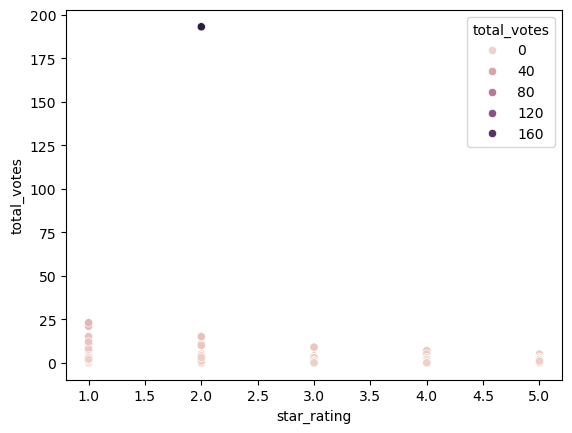

In [111]:
sns.scatterplot(data=df, x="star_rating",y='total_votes',hue="total_votes")

<AxesSubplot:xlabel='helpful_votes', ylabel='total_votes'>

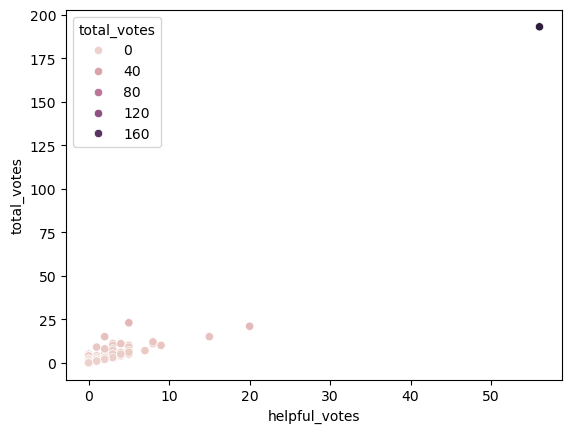

In [112]:
sns.scatterplot(data=df, x="helpful_votes",y='total_votes',hue="total_votes")

<AxesSubplot:>

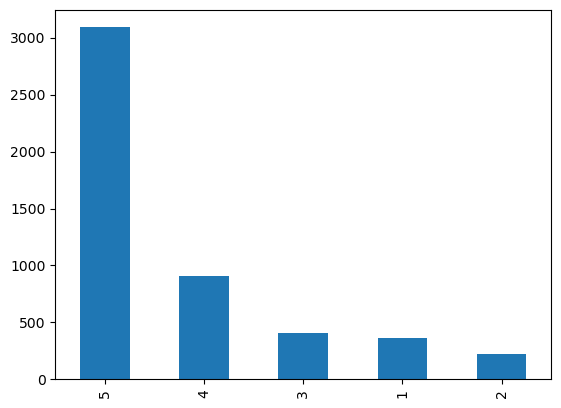

In [113]:
df["star_rating"].value_counts().plot.bar()

<AxesSubplot:>

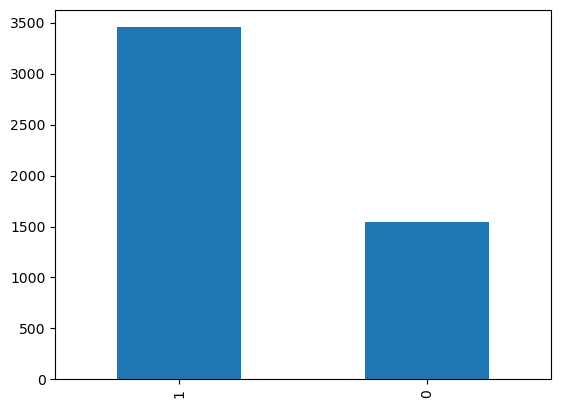

In [114]:
df["verified_purchase"].value_counts().plot.bar()

In [115]:
import re
df['review_body'] = df['review_body'].str.replace('<br /><br />', '', regex=False)
df['review_body'] = df['review_body'].str.replace(r'<br\s*/?>', ' ', regex=True, flags=re.IGNORECASE)


# Create X and y Feature variables

In [116]:
X,y = df.drop("sentiment", axis=1), df["sentiment"]

In [117]:
vectorizer = TfidfVectorizer(max_features=2000)

tfidf_matrix = vectorizer.fit_transform(df['review_body'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate with original data
X = pd.concat([X.drop("review_body", axis=1), tfidf_df], axis=1)

# Baseline Model Testing

In [118]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='stratified', constant=1) 

scores = evaluate_model(X, y, model)
print('Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean: 0.686 (0.017)


# Advanced Model Metrics

In [119]:
names = ['LR', 'SVC', 'GBC', 'XGB','GNB', 'KNN', 'DTC', 'RFC', 'GPC', 'LDA']

models = get_selected_models(names)
testing_selected_models(names, models, X, y)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
